In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fx_rates = pd.read_excel("./Data/FX_ALL_MONTHLY.xlsx", index_col=0)
fx_rates = fx_rates[fx_rates!=0].dropna()
fx_rates.index = pd.to_datetime(fx_rates.index)
fx_rates = fx_rates.sort_index()
equities = pd.read_excel("./Data/MSCI_ALL_LOCAL_MONTHLY.xlsx", index_col=0, sheet_name="Sheet1")
equities = equities.sort_index()
interestrates = pd.read_excel("./Data/3M_INTEREST_RATES_MONTHLY.xlsx", index_col=0).dropna()
interestrates.columns=pd.read_excel("./Data/3M_interest_rates.xlsx").columns
interestrates.index = pd.to_datetime(interestrates.index)
interestrates = interestrates.sort_index()

In [3]:
def excess_equity_returns(equity_returns, stfir):
    #stfir: short-term foreign interest rate (quoted per annum)
    
    # ensure index is sorted
    equity_returns = equity_returns.sort_index()
    stfir = stfir.sort_index()
    
    #ensure index matches
    equity_returns = equity_returns[equity_returns.index.isin(stfir.index)]
    stfir = stfir[stfir.index.isin(equity_returns.index)]
    
    return equity_returns - ((1+stfir)**(1/4)-1)

def excess_currency_returns(r_fx, fi, di):
    # r_fx: exchange rate returns, fi: foreign interest rate, di: domestic interest rate
    # calculate returns by using a 3 month shift
    # Appreciation in the rate means an increase in the value of domestic currency so returns are calculated on inverse
    r_fx = ((1/r_fx.iloc[3:,:].values)/(1/r_fx.iloc[:-3,:]) -1)
    # exclude domestic currency name from fx rate names
    r_fx.columns = [name.replace(di.name, "") for name in r_fx.columns]
    # sort the columns as in the interest rates df
    r_fx = r_fx[fi.columns]
    ans = r_fx + (fi.sub(di, axis="rows"))
    # adjust for domestic currency
    #    ans[di.name] = 0
    return ans

def sigma_fx_func(r_fx, fi, di):
    # get excess returns
    excess_r = excess_currency_returns(r_fx, fi, di)
    # return their variance-covariance matirx / pandas cov()
    return excess_r.cov()

def get_weights(alpha_eq, alpha_fx, max_leverage=None):
    # alpha_eq: expected excess returns for hedged equities, alpha_fx:  currency expected excess returns
    alpha_fx = alpha_fx[alpha_eq.columns]
    sigma_fx = alpha_fx.cov()
    sigma_fx_inv = np.linalg.pinv(sigma_fx)
    sigma_eqfx = pd.Series({cur:alpha_fx[cur].cov(alpha_eq[cur]) for cur in alpha_fx.columns})
    
    
    w_hedge = -np.matmul(sigma_fx_inv, sigma_eqfx)
    w_alpha = np.matmul(sigma_fx_inv,alpha_fx.mean())
    
    alpha_minvar = alpha_eq.mean() - np.matmul(alpha_fx.mean(), np.matmul(sigma_fx_inv, sigma_eqfx)) # done
    sigma_minvar = alpha_eq.std()**2 - np.matmul(sigma_eqfx.T, np.matmul(sigma_fx_inv, sigma_eqfx)) # done
   
    k_opt = np.matmul(sigma_minvar,1/alpha_minvar.T)
    w_opt = w_hedge - np.matmul(k_opt, w_hedge)
    if not max_leverage is None:
        if w_hedge.abs().sum()/2 > max_leverage:
            w_hedge = w_hedge/(w_hedge.abs().sum()/(2*max_leverage))
        if w_opt.abs().sum()/2 > max_leverage:
            w_opt = w_opt/(w_opt.abs().sum()/(2*max_leverage))
        if w_alpha.abs().sum()/2 > max_leverage:
            w_alpha = w_alpha/(w_alpha.abs().sum()/(2*max_leverage))
    return w_opt, w_hedge, w_alpha, k_opt
  

In [4]:
domestic_currency="CHF"
# Calculate Excess Equity returns
# Calculate returns for 3 month holing period in local currencies
eq_returns = equities.rolling(3).agg(lambda x: (x[-1]/x[0]-1))
# Calculate excess returns
alpha_eq = pd.DataFrame(columns=interestrates.columns, index = interestrates.index)
alpha_eq["CHF"] = excess_equity_returns(eq_returns["MXUS Index"], interestrates["CHF"])
alpha_eq["USD"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["USD"][:-3])
alpha_eq["EUR"] = excess_equity_returns(eq_returns["MSDLUK Index"], interestrates["EUR"][:-3])
alpha_eq["CAD"] = excess_equity_returns(eq_returns["MSDLCA Index"], interestrates["CAD"][:-3])
alpha_eq["GBP"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["GBP"][:-3])
alpha_eq["JPY"] = excess_equity_returns(eq_returns["MSDLJN Index"], interestrates["JPY"][:-3])
alpha_eq["AUD"] = excess_equity_returns(eq_returns["MSDLAS Index"], interestrates["AUD"][:-3])

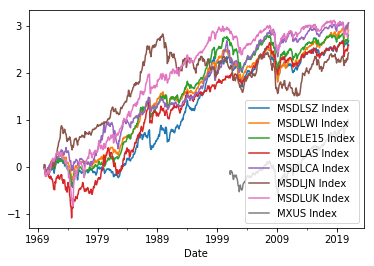

In [5]:
# Cumulative monthly log returns
np.log(1+(equities.pct_change())).cumsum().plot()

In [6]:
# Calculate Excess Currency returns
interestrates = interestrates[interestrates.index.isin(fx_rates.index)]
fx_rates = fx_rates[fx_rates.index.isin(interestrates.index)]
fi = interestrates[[cur for cur in interestrates.columns if cur != domestic_currency ]]
di = interestrates[domestic_currency]
alpha_fx = excess_currency_returns(fx_rates, fi, di)

In [55]:
# Read in the MSCI World country Weights
country_weights = pd.read_csv("./MSCIWorldCurrencyWeights.csv", index_col=0, parse_dates=True)[alpha_eq.columns]
country_weights = country_weights[country_weights!=0].dropna().sort_index()

# Only Select the used currencies
alpha_eq = alpha_eq.sort_index()
country_weights_in_data = country_weights[country_weights.index.isin(alpha_eq.index)]
alpha_eq = alpha_eq[alpha_eq.index.isin(country_weights_in_data.index)]

In [62]:
index_alpha_eq = alpha_eq.multiply(country_weights_in_data)

In [63]:
sr_opti_w = get_weights(index_alpha_eq[[col for col in index_alpha_eq if col != "CHF"]], alpha_fx, 2)

In [64]:
sr_opti_w


(USD    0.088773
 EUR    0.088484
 GBP   -0.149149
 JPY   -0.028654
 CAD   -0.398280
 AUD   -0.142731
 dtype: float64, USD    0.207905
 EUR    0.207616
 GBP   -0.030017
 JPY    0.090478
 CAD   -0.279149
 AUD   -0.023599
 dtype: float64, USD   -0.196427
 EUR   -0.695320
 GBP   -0.374069
 JPY   -0.364926
 CAD    1.234899
 AUD    1.134358
 dtype: float64, USD    0.687692
 EUR    0.687692
 GBP    0.687692
 JPY    0.687692
 CAD    0.687692
 AUD    0.687692
 dtype: float64)

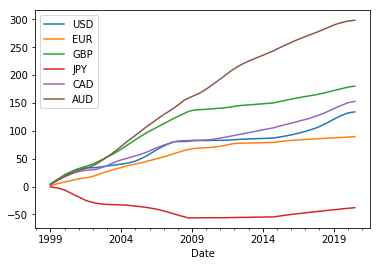

In [65]:
alpha_fx.iloc[::3].cumsum().plot()

In [66]:
# For every 3 months, find the weights
# # find daily forex excess retrns
# For every month with weights, simulate hedging
# Plot the results

In [67]:
daycountconvention = 365
month = daycountconvention / 12
daily_interestrates = (pd.read_excel("./Data/3M_interest_rates.xlsx", index_col=0, header=0).iloc[1:,:].dropna()/100).sort_index()
daily_interestrates.index = pd.to_datetime(daily_interestrates.index)
for col in daily_interestrates.columns:
    daily_interestrates[col] = daily_interestrates[col].apply(lambda x: np.log(1+x)/daycountconvention)
with np.errstate(divide='ignore'):
    daily_fx_returns = np.log((1/pd.read_excel("./Data/FX_CHF_ALL_1971-2020.xlsx", index_col=0).sort_index()).pct_change().dropna()+1)
daily_fx_returns.index = pd.to_datetime(daily_fx_returns.index)


In [68]:
daily_fi = daily_interestrates[[col for col in daily_interestrates.columns if col != "CHF"]]
daily_di = daily_interestrates["CHF"]
#daily_fx_returns = daily_fx_returns[daily_fx_returns.indrx.isin()]
daily_fx_returns.columns = [name.replace(daily_di.name, "") for name in daily_fx_returns.columns]
daily_fx_excess = (daily_fx_returns + daily_fi.sub(daily_di, axis="rows")).dropna()

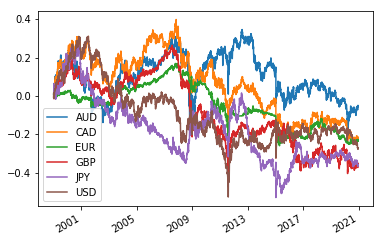

In [69]:
# Plotting daily cumlative currency excess returns
daily_fx_excess.cumsum().plot()

In [70]:
equities = pd.read_excel("./Data/MSCI_ALL_USD_CHF.xlsx", index_col=0, header=3, sheet_name="CleanTimeSeries")
equities.columns = ["Switzerland","World","Europe","Australia","Canada","Japan","UK","USA"]
equities = equities[["Switzerland","Europe","Australia","Canada","Japan","UK","USA"]]
equities.columns = ["CHF","EUR","AUD","CAD","JPY","GBP","USD"]
equities = equities.sort_index()
equities_returns = np.log(equities.pct_change()+1)
excess_equities_returns = equities_returns.sub(daily_interestrates)
excess_equities_returns=excess_equities_returns.dropna()

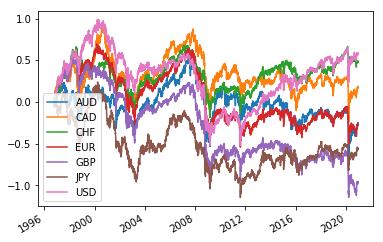

In [71]:
excess_equities_returns.cumsum().plot()

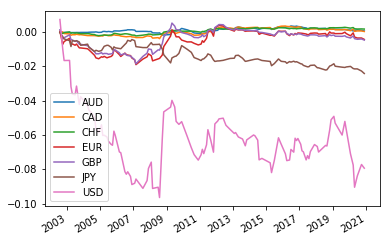

In [84]:
country_weights_in_data = country_weights[country_weights.index.isin(excess_equities_returns.index)].sort_index()
index_weighted_excess_returns = excess_equities_returns[excess_equities_returns.index.isin(country_weights_in_data.index)].sort_index().multiply(country_weights_in_data)
index_weighted_excess_returns.cumsum().plot()


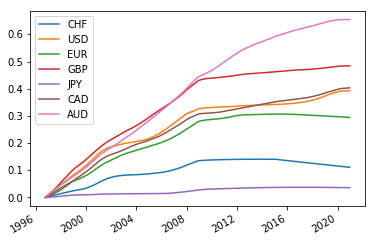

In [85]:
daily_interestrates.cumsum().plot()


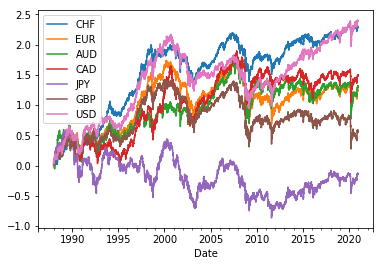

In [86]:
equities_returns.cumsum().plot()

In [87]:
# Weights of entire period
get_weights(index_weighted_excess_returns[[col for col in index_weighted_excess_returns.columns if col != "CHF"]], daily_fx_excess[[col for col in daily_fx_excess.columns if col != "CHF"]])

(AUD    1.042200
 CAD    1.883941
 EUR    1.154614
 GBP    1.514862
 JPY    1.692104
 USD   -0.633119
 dtype: float64, AUD   -0.088606
 CAD    0.753136
 EUR    0.023808
 GBP    0.384056
 JPY    0.561298
 USD   -1.763925
 dtype: float64, AUD    0.855728
 CAD    0.086211
 EUR   -1.693643
 GBP   -1.248430
 JPY   -0.854215
 USD    0.362679
 dtype: float64, AUD    8.682927
 CAD    8.682927
 EUR    8.682927
 GBP    8.682927
 JPY    8.682927
 USD    8.682927
 dtype: float64)

In [89]:
# find appropriate currency weights for each month
months_to_simulate=3
months = list(set([(x.year, x.month) for x in excess_equities_returns.index]))
excess_equities_returns=excess_equities_returns.dropna()
daily_fx_excess = daily_fx_excess.dropna()
excess_equities_returns=excess_equities_returns[excess_equities_returns.index.isin(daily_fx_excess.index)]
daily_fx_excess=daily_fx_excess[daily_fx_excess.index.isin(excess_equities_returns.index)]

excess_equities_returns=excess_equities_returns[[col for col in excess_equities_returns.columns if col != "CHF"]]
daily_fx_excess=daily_fx_excess[[col for col in daily_fx_excess.columns if col != "CHF"]]

get_data = lambda y,m: (excess_equities_returns[(excess_equities_returns.index.year.isin(y))&(excess_equities_returns.index.month.isin(m))], daily_fx_excess[(daily_fx_excess.index.year.isin(y)) & (daily_fx_excess.index.month.isin(m))])
#weights = pd.DataFrame(index=pd.to_datetime([dt.date(year=x[0], month=x[1], day=1) for x in months[3:]]), columns=daily_fx_excess.columns) 
sr_weights=dict()
hedge_weights=dict()
alpha_weights=dict()
k=dict()
for i in range(len(months)-months_to_simulate):
    y,m = list(zip(*months[i:i+(months_to_simulate-1)]))
    fx, eq = get_data(y,m)
    year,month = months[i+months_to_simulate]
    time_index = pd.to_datetime(dt.date(year=year,month=month,day=1))
    sr_weights[time_index], hedge_weights[time_index], alpha_weights[time_index], k[time_index]= get_weights(eq,fx, 1)

sr_weights = pd.DataFrame(sr_weights).T.sort_index()
hedge_weights = pd.DataFrame(hedge_weights).T.sort_index()
alpha_weights = pd.DataFrame(alpha_weights).T.sort_index()
k = pd.DataFrame(k).T.sort_index()

In [90]:
#simulate returns with currency weights for each month

In [91]:
daily_fx_returns_with_interest = daily_fx_excess.add(daily_fi).dropna()
monthly_fx_interest_returns = daily_fx_returns_with_interest.groupby([daily_fx_returns_with_interest.index.year, daily_fx_returns_with_interest.index.month]).agg(lambda x: x.sum())
monthly_fx_interest_returns.index=pd.to_datetime(list(dt.date(year=x[0], month=x[1], day=1) for x in monthly_fx_interest_returns.index))

In [92]:
monthly_fx_interest_returns = monthly_fx_interest_returns[monthly_fx_interest_returns.index.isin(sr_weights.index)]
sr_weights = sr_weights[sr_weights.index.isin(monthly_fx_interest_returns.index)]
hedge_weights = hedge_weights[hedge_weights.index.isin(monthly_fx_interest_returns.index)]
alpha_weights = alpha_weights[alpha_weights.index.isin(monthly_fx_interest_returns.index)]


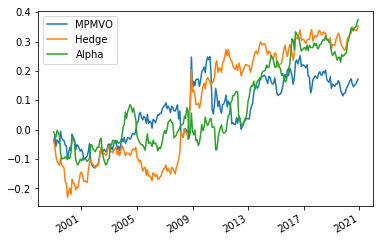

In [109]:
#plotting cumulative return of the sharp ratio omtimizing hedge
equity_portfolio = equities_returns[equities_returns.index.isin(country_weights_in_data.index)].sort_index().multiply(country_weights_in_data)
portfolios = pd.DataFrame(index=monthly_fx_interest_returns.index)
portfolios["MPMVO"] = monthly_fx_interest_returns.multiply(sr_weights).sum(axis=1).cumsum()
portfolios["Hedge"] = monthly_fx_interest_returns.multiply(hedge_weights).sum(axis=1).cumsum()
portfolios["Alpha"] = monthly_fx_interest_returns.multiply(alpha_weights).sum(axis=1).cumsum()
portfolios.plot()




In [94]:
portfolios.std()

MPMVO    0.100677
Hedge    0.191906
Alpha    0.142862
dtype: float64

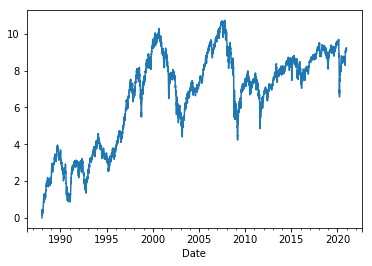

In [110]:
equities_returns.sum(axis=1).cumsum().plot()

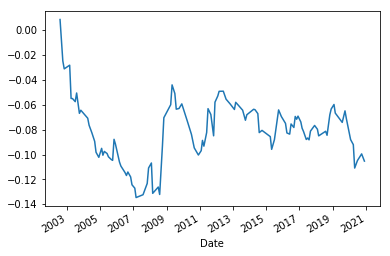

In [111]:
equity_portfolio.sum(axis=1).cumsum().plot()

In [95]:
portfolios.std()**2/portfolios.mean()

MPMVO    0.138078
Hedge    0.402756
Alpha    0.252107
dtype: float64

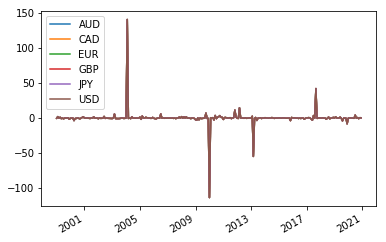

In [96]:
k.plot()

In [97]:
sr_weights.abs().sum(axis=1)/2

1999-01-01    1.000000
1999-02-01    1.000000
1999-03-01    1.000000
1999-04-01    1.000000
1999-05-01    1.000000
1999-06-01    1.000000
1999-07-01    1.000000
1999-08-01    1.000000
1999-09-01    1.000000
1999-10-01    1.000000
1999-11-01    0.941280
1999-12-01    1.000000
2000-01-01    1.000000
2000-02-01    1.000000
2000-03-01    1.000000
2000-04-01    1.000000
2000-05-01    1.000000
2000-06-01    1.000000
2000-07-01    0.584481
2000-08-01    1.000000
2000-09-01    1.000000
2000-10-01    1.000000
2000-12-01    1.000000
2001-01-01    1.000000
2001-02-01    1.000000
2001-03-01    1.000000
2001-04-01    1.000000
2001-06-01    1.000000
2001-07-01    1.000000
2001-08-01    1.000000
                ...   
2018-07-01    0.515085
2018-08-01    1.000000
2018-09-01    1.000000
2018-10-01    1.000000
2018-11-01    1.000000
2018-12-01    1.000000
2019-01-01    1.000000
2019-02-01    1.000000
2019-03-01    1.000000
2019-04-01    1.000000
2019-05-01    1.000000
2019-06-01    1.000000
2019-07-01 

# 